# Lab 02 - Decision Tree - II

In this lab we are trying to do some more cleaning on our data, learn more on analyzing and preparing data, tune 
hyperparameters and evaluate our models.

Let us get back to the state where we left last week.

#### Import libraries

In [1]:
# data analysis and preparing
import pandas as pd
import numpy as np
import random as rnd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics, tree

#### Acquire data
 

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_merged.csv')

combine = [train_df, test_df]

#### Prepare and clean data

In [3]:
for df in combine:
    df.drop('Cabin', axis=1, inplace=True)
    
for df in combine:
    df.drop(columns=['Ticket', 'PassengerId'], inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode(dropna=True)[0], inplace=True)

In [4]:
num_encode = {
    'Sex': {'male': 0, "female": 1},
    'Embarked': {'S': 0, 'Q': 1, 'C': 2 }
}

for df in combine:
    df.replace(num_encode, inplace=True)


### Data preparation continued...

As we observed last week, Age is a really good feature. Let's prepare it for the algorithm.

### Completing a numerical continuous feature

We can consider three methods to complete a numerical continuous feature.

1. A simple way is to generate random numbers between mean and standard deviation.

2. More accurate way of guessing missing values is to use other correlated features. In our case we note correlation 
among Age, Gender, and Pclass. Guess Age values using median values for Age across sets of Pclass and Gender feature 
combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...

3. Combine methods 1 and 2. Instead of guessing age values based on median, use random numbers between mean and 
standard deviation, based on sets of Pclass and Gender combinations.

Method 1 and 3 can introduce random noise into our models. The results from multiple executions might vary. Because of 
that we will prefer method 2. But you can try any one of these methods in your experiments.

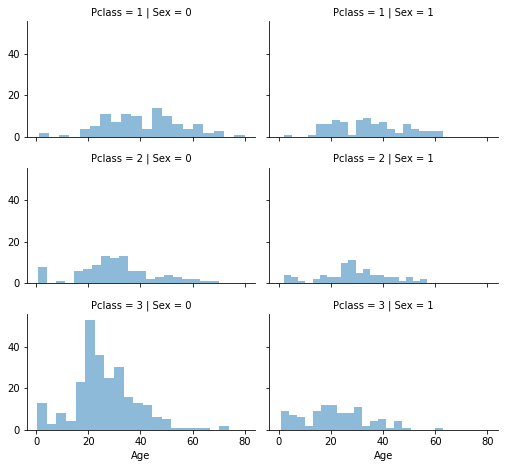

In [5]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations.

In [6]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.

In [7]:
pd.set_option('mode.chained_assignment',None)

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()
            age_guess = guess_df.median()
            
            guess_ages[i,j] = int(age_guess)
            
    for i in range(0, 2):
        for j in range(0, 3):
            mask = dataset[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1)]     
            if mask.empty:
                continue
            
            dataset.loc[mask.index , 'Age'] = int(guess_ages[i, j])    
                
    # dataset.loc[:, 'Age'] = dataset['Age'].astype(int)

In [8]:
train_df.head()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    int64  
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 62.8+ KB


Now we have to convert the continuous feature to categorical feature to use it in our models. Let us create Age bands
and determine correlations with Survived.

In [9]:
train_df['AgeBand'] = pd.cut(train_df['Age'],bins=[0,2,17,65,99], labels=['Toddler/baby','Child','Adult','Elderly'])
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,Toddler/baby,0.625000
1,Child,0.516854
2,Adult,0.363636
3,Elderly,0.125000


Let us replace Age with ordinals based on these bands.

In [10]:
train_df.drop('AgeBand', inplace=True, axis=1)
for df in combine:
    category = pd.cut(df.Age,bins=[0,2,17,65,99], labels=[0, 1, 2, 3])
    df.insert(5,'AgeBand', category)

train_df.head()

,Survived,Pclass,Name,Sex,Age,AgeBand,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,2,1,0,7.2500,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,2,1,0,71.2833,2
2,1,3,"Heikkinen, Miss. Laina",1,26.0,2,0,0,7.9250,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,2,1,0,53.1000,0
4,0,3,"Allen, Mr. William Henry",0,35.0,2,0,0,8.0500,0


Let's Consider the Fare feature now.

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

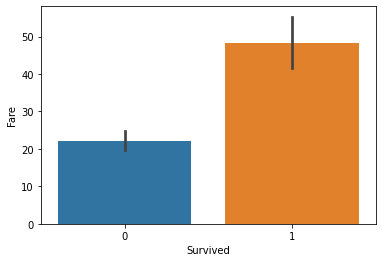

In [11]:
sns.barplot(x='Survived', y='Fare', data=train_df)

We can see that the survived people on average has paid more fare compared to those who did not survive.  

Let's complete the feature by assigning most frequent fare to all missing values.

In [12]:
for dataset in combine:
    dataset['Fare'].fillna(dataset['Fare'].mode(dropna=True)[0], inplace=True)

Let's try to create Fare bands using quartile values.

In [13]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


It seems like Fare bands give us good information on who has the least probability to survive. Let's make it an ordinal
feature.

In [14]:
train_df.drop(['FareBand'], axis=1, inplace=True)
for df in combine:
    category = pd.qcut(df.Fare, q=4, labels=[0, 1, 2, 3])
    df.insert(5,'FareBand', category)

train_df.head()

,Survived,Pclass,Name,Sex,Age,FareBand,AgeBand,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,0,2,1,0,7.2500,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,3,2,1,0,71.2833,2
2,1,3,"Heikkinen, Miss. Laina",1,26.0,1,2,0,0,7.9250,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,3,2,1,0,53.1000,0
4,0,3,"Allen, Mr. William Henry",0,35.0,1,2,0,0,8.0500,0


### Creating new features extracting from existing features

##### Title from Name

We want to analyze if Name feature can be engineered to extract titles and test correlation between titles and survival,
 before dropping Name feature.

In the following code we extract Title feature using regular expressions. The RegEx pattern `(\w+\.)` matches the first 
word which ends with a dot character within Name feature. The `expand=False` flag returns a DataFrame.

In [15]:
train_df['Title'] = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train_df['Title'], train_df['AgeBand'])

AgeBand,0,1,2,3
Title,,,,
Capt,0,0,0,1
Col,0,0,2,0
Countess,0,0,1,0
Don,0,0,1,0
Dr,0,0,7,0
Jonkheer,0,0,1,0
Lady,0,0,1,0
Major,0,0,2,0
Master,14,22,4,0


In [16]:
pd.crosstab(train_df['Title'], train_df['Survived'])

Survived,0,1
Title,,
Capt,1,0
Col,1,1
Countess,0,1
Don,1,0
Dr,4,3
Jonkheer,1,0
Lady,0,1
Major,1,1
Master,17,23


From the above visualizations, we can note the following observations.

- Most titles band Age groups accurately. For example: Master title has Age less than 17 years.
- Survival among Title bands varies slightly.
- Certain titles mostly survived (Mme, Lady, Sir) or did not (Don, Rev, Jonkheer).

So this feature might be helpful to us.

In [17]:
train_df.drop(['Title'], axis=1, inplace=True)
for df in combine:
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    

We can replace many titles with a more common name or classify them as `Rare`.

In [18]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df.head()

,Survived,Pclass,Name,Sex,Age,FareBand,AgeBand,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",0,22.0,0,2,1,0,7.2500,0,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,3,2,1,0,71.2833,2,Mrs
2,1,3,"Heikkinen, Miss. Laina",1,26.0,1,2,0,0,7.9250,0,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,3,2,1,0,53.1000,0,Mrs
4,0,3,"Allen, Mr. William Henry",0,35.0,1,2,0,0,8.0500,0,Mr


Let's turn these categorical titles to ordinal.

In [19]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()


,Survived,Pclass,Name,Sex,Age,FareBand,AgeBand,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",0,22.0,0,2,1,0,7.2500,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,3,2,1,0,71.2833,2,3
2,1,3,"Heikkinen, Miss. Laina",1,26.0,1,2,0,0,7.9250,0,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,3,2,1,0,53.1000,0,3
4,0,3,"Allen, Mr. William Henry",0,35.0,1,2,0,0,8.0500,0,1


Now we can safely drop the Name feature from datasets.

In [20]:
for dataset in combine:
    dataset.drop('Name', inplace=True, axis=1)
    

#### Family size from SibSp and Parch

From our analysis last week, we figured out that 'SibSp' and 'Parch' are not very good features. So let us make a new 
feature called 'FamilySize', combining those features. 

In [21]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1    
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


As we can see, this feature can be useful for our models. But it has a few too many categories. Let us create a feature 
called IsAlone from this feature to minimize complexity. 

In [22]:
train_df.drop(['FamilySize'], axis=1, inplace=True)
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

Let us drop 'Family size'.

In [23]:
for dataset in combine:
    dataset.drop(['FamilySize'], axis=1, inplace=True)
    
train_df.head()

,Survived,Pclass,Sex,Age,FareBand,AgeBand,SibSp,Parch,Fare,Embarked,Title,IsAlone
0,0,3,0,22.0,0,2,1,0,7.2500,0,1,0
1,1,1,1,38.0,3,2,1,0,71.2833,2,3,0
2,1,3,1,26.0,1,2,0,0,7.9250,0,2,1
3,1,1,1,35.0,3,2,1,0,53.1000,0,3,0
4,0,3,0,35.0,1,2,0,0,8.0500,0,1,1


## Model, Predict and Evaluation

Let's make training, validation and test sets from data.

In [24]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

X_test = test_df.drop('Survived', axis=1)
y_test = test_df['Survived']

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=27)

combine = [X_train, X_valid, X_test]

Let's recreate the decision tree model we built last week.

In [26]:
X_train_cat = X_train[['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']]
X_valid_cat = X_valid[['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']]

cat_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
cat_tree.fit(X_train_cat, y_train)
y_pred = cat_tree.predict(X_valid_cat)

print("Accuracy:", metrics.accuracy_score(y_valid, y_pred))

Accuracy: 0.7835820895522388


#### Evaluation

You can get a different types of evaluation metrics from the sci-kit learn. First let's generate the confusion matrix 
for our prediction. 

In [27]:
print(metrics.confusion_matrix(y_valid, y_pred))

[[150  17]
 [ 41  60]]


The index mapping of the above matrix is as follows,

- [0, 0] - True Positive
- [0, 1] - False Negative
- [1, 0] - False Positive
- [1, 1] - True Negative

Let's generate the classification report of our predicted data. Classification report contains information such as 
accuracy and precision, recall and f1-score for each output class.
You can get more information on classification report here: 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

In [28]:
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       167
           1       0.78      0.59      0.67       101

    accuracy                           0.78       268
   macro avg       0.78      0.75      0.76       268
weighted avg       0.78      0.78      0.78       268



#### Back to modeling.

Let us add the new features we curated and try to train a new model.

In [29]:
X_train.drop(['SibSp', 'Parch', 'Fare'], axis=1, inplace=True)
X_test.drop(['SibSp', 'Parch', 'Fare'], axis=1, inplace=True)
X_valid.drop(['SibSp', 'Parch', 'Fare'], axis=1, inplace=True)

In [30]:
entropy_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
entropy_tree.fit(X_train, y_train)
y_pred = entropy_tree.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       167
           1       0.72      0.62      0.67       101

    accuracy                           0.77       268
   macro avg       0.76      0.74      0.75       268
weighted avg       0.77      0.77      0.76       268



Let's try to plot this decision tree. We can use plot_tree() function in sci_kit learn to visualize the tree you modeled.

[Text(177.46009615384617, 211.7178947368421, 'X[6] <= 1.5\nentropy = 0.963\nsamples = 623\nvalue = [382, 241]'),
 Text(86.11442307692307, 200.2736842105263, 'X[0] <= 1.5\nentropy = 0.616\nsamples = 367\nvalue = [311, 56]'),
 Text(42.02884615384615, 188.82947368421054, 'X[2] <= 48.5\nentropy = 0.918\nsamples = 78\nvalue = [52, 26]'),
 Text(26.111538461538462, 177.38526315789474, 'X[2] <= 47.5\nentropy = 0.978\nsamples = 58\nvalue = [34, 24]'),
 Text(23.25, 165.94105263157894, 'X[3] <= 2.5\nentropy = 0.959\nsamples = 55\nvalue = [34, 21]'),
 Text(5.723076923076923, 154.49684210526317, 'X[3] <= 1.0\nentropy = 0.985\nsamples = 21\nvalue = [9, 12]'),
 Text(2.8615384615384616, 143.05263157894737, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(8.584615384615384, 143.05263157894737, 'X[2] <= 28.5\nentropy = 0.918\nsamples = 18\nvalue = [6, 12]'),
 Text(5.723076923076923, 131.60842105263157, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(11.446153846153846, 131.60842105263157, 'X[2]

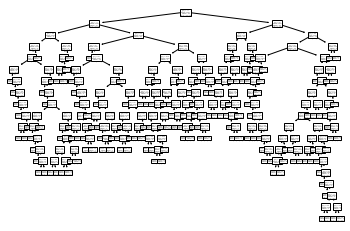

In [31]:
tree.plot_tree(entropy_tree)

As you can see, our decision tree is huge, and this can cause overfitting. To reduce overfitting we can use pruning 
methods.

In decision trees, one method of pre-pruning is early stopping. We can limit the max depth of the tree and limit 
overfitting. Let's limit our tree to 8 levels.

In [32]:
entropy_tree_lim_eight = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)
entropy_tree_lim_eight.fit(X_train, y_train)
y_pred = entropy_tree_lim_eight.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       167
           1       0.76      0.63      0.69       101

    accuracy                           0.79       268
   macro avg       0.78      0.76      0.76       268
weighted avg       0.78      0.79      0.78       268



We can see a performance improvement after the pre-pruning. 

#### Hyperparameter tuning

To improve our model performance, we can do two things, feature engineering and hyperparameter tuning. We already did
feature engineering to improve the quality of our data. Now it is time for hyperparameter tuning. Hyperparamteres are 
the small properties in machine learning algorithms that we can use to optimize the model. There is no 
algorithmic method to do this other than trial and error.

What are the hyperparameters in 
[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)?
* Almost all input parameters of the model definition interface are hyperparameters.
 
Let's create and train few models with different sets of values for parameters. I chose following parameters, 
- criterion
- max_depth


In [33]:
# ['entropy', '5']
entropy_tree_ent_five = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
entropy_tree_ent_five.fit(X_train, y_train)
y_pred = entropy_tree_ent_five.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       167
           1       0.78      0.59      0.67       101

    accuracy                           0.78       268
   macro avg       0.78      0.75      0.76       268
weighted avg       0.78      0.78      0.78       268



In [34]:
# ['entropy', '7']
entropy_tree_ent_seven = DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)
entropy_tree_ent_seven.fit(X_train, y_train)
y_pred = entropy_tree_ent_seven.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       167
           1       0.72      0.57      0.64       101

    accuracy                           0.76       268
   macro avg       0.75      0.72      0.73       268
weighted avg       0.75      0.76      0.75       268



In [35]:
# ['entropy', '12']
entropy_tree_ent_twelve = DecisionTreeClassifier(criterion='entropy', max_depth=12, random_state=42)
entropy_tree_ent_twelve.fit(X_train, y_train)
y_pred = entropy_tree_ent_twelve.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       167
           1       0.72      0.61      0.66       101

    accuracy                           0.76       268
   macro avg       0.75      0.74      0.74       268
weighted avg       0.76      0.76      0.76       268



In [36]:
# ['gini', '5']
entropy_tree_gini_five = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
entropy_tree_gini_five.fit(X_train, y_train)
y_pred = entropy_tree_gini_five.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       167
           1       0.79      0.57      0.67       101

    accuracy                           0.78       268
   macro avg       0.79      0.74      0.75       268
weighted avg       0.79      0.78      0.77       268



In [37]:
# ['gini', '7']
entropy_tree_gini_seven = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=42)
entropy_tree_gini_seven.fit(X_train, y_train)
y_pred = entropy_tree_gini_seven.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       167
           1       0.74      0.58      0.65       101

    accuracy                           0.76       268
   macro avg       0.76      0.73      0.74       268
weighted avg       0.76      0.76      0.76       268



In [38]:
# ['gini', '8']
entropy_tree_gini_eight = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42)
entropy_tree_gini_eight.fit(X_train, y_train)
y_pred = entropy_tree_gini_eight.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       167
           1       0.74      0.71      0.73       101

    accuracy                           0.80       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268



In [39]:
# ['gini', '12']
entropy_tree_gini_twelve = DecisionTreeClassifier(criterion='gini', max_depth=12, random_state=42)
entropy_tree_gini_twelve.fit(X_train, y_train)
y_pred = entropy_tree_gini_twelve.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       167
           1       0.74      0.61      0.67       101

    accuracy                           0.77       268
   macro avg       0.76      0.74      0.75       268
weighted avg       0.77      0.77      0.77       268



From these results we can pick ['gini', '8'] as the best performing model in validation stage.

Now let's use the test dataset to find how good our model is.

In [41]:
y_pred =  entropy_tree_gini_eight.predict(X_test)

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       266
           1       0.71      0.78      0.74       152

    accuracy                           0.80       418
   macro avg       0.79      0.80      0.79       418
weighted avg       0.81      0.80      0.81       418



## Task

Use your cleaned dataset from last week,
- Complete all the features. 
- Try to figure out which variables are useful and which are not.
- Create few models with different feature sets and evaluate them.
- Tune the parameters of the models and figure out which values give you the best performance.
- Finally, after deciding the best model, use the test set to measure the performance of your model.